# Springboard - Data Science Career Track

# Capstone Project I: Kiva.org loan delays

In [1]:
# link for the data
kiva_url = "https://www.kaggle.com/lucian18/mpi-on-regions#all_kiva_loans.csv"

### Goal of the project:
    
**Understand what may cause a higher delay between:**

-  the "posted time" (the time at which the loan is posted on Kiva by the field agent)
-  the "funded time" (the time at which the loan posted to Kiva gets 100% funded by lenders)
- the "disbursed time" (the time at which the loan is disbursed by the field agent to the borrower)

#### **The journey of a Kiva loan**

- A borrower applies for a loan.
- The loan goes through the underwriting and approval process
- If it is approved, the loan disbursal period starts
    - The loan is posted to Kiva for lenders to support
    - Fundraising period
    - Fundraising complete (or not)
- Borrower repays the loan
- Lenders use repayments to fund new loans, donate or withdraw the money.

Partner loans are administered by Kiva’s Field Partners and are available to borrowers in more than 80 countries. Direct loans are made using the digital payment system and don’t involve a Field Partner.

**Note**: *Disbursal* refers to when the borrower can access the money, but the timing of it can vary:    
  - For most Field Partner loans, the money is *pre-disbursed* (when partners give the funds out before the loan is posted), so the borrower can access the funds right away. 
  - For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

### Libraries

In [2]:
# relevant modules
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from collections import Counter


## 1) Data inspection and Cleaning

In [3]:
# filename
kiva_data = pd.read_csv("all_kiva_loans_copy.csv")

### Overview and cleaning

In [4]:
kiva_data.head(3)

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
0,657307,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,...,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,female,irregular
1,657259,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",...,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,female,monthly
2,658010,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,...,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,female,monthly


In [5]:
kiva_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1419607 non-null int64
funded_amount              1419607 non-null float64
loan_amount                1419607 non-null float64
status                     1419607 non-null object
activity_name              1419607 non-null object
sector_name                1419607 non-null object
loan_use                   1376334 non-null object
country_code               1419598 non-null object
country_name               1419607 non-null object
town_name                  1257849 non-null object
currency_policy            1419607 non-null object
currency                   1419607 non-null object
partner_id                 1402817 non-null float64
posted_time                1419607 non-null object
planned_expiration_time    1047773 non-null object
disburse_time              1416794 non-null object
raised_time                1355325 non-null object
lender_term       

In [6]:
# describe dataframe numericals
kiva_data.describe()

,loan_id,funded_amount,loan_amount,partner_id,lender_term,num_lenders_total
count,1.419607e+06,1.419607e+06,1.419607e+06,1.402817e+06,1.419583e+06,1.419607e+06
mean,7.233713e+05,7.961254e+02,8.322284e+02,1.496207e+02,1.305139e+01,2.225389e+01
std,4.156766e+05,1.034257e+03,1.080551e+03,8.769345e+01,7.566660e+00,2.777410e+01
min,8.400000e+01,0.000000e+00,2.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.642165e+05,2.750000e+02,3.000000e+02,9.800000e+01,8.000000e+00,8.000000e+00
50%,7.240350e+05,5.000000e+02,5.000000e+02,1.390000e+02,1.200000e+01,1.500000e+01
75%,1.082972e+06,9.500000e+02,1.000000e+03,1.740000e+02,1.400000e+01,2.700000e+01
max,1.444085e+06,1.000000e+05,1.000000e+05,5.570000e+02,1.950000e+02,3.045000e+03


#### Changing dtpes and labels

In [7]:
# Changing some column names, for clarity
kiva_data.rename(columns={'disburse_time':'disbursed_time', 'raised_time':'funded_time'}, inplace=True)

In [8]:
# change the dtype of the main variables of study to datetime64[ns]
kiva_data['posted_time'] = pd.to_datetime(kiva_data['posted_time'], errors='coerce')
kiva_data['planned_expiration_time'] = pd.to_datetime(kiva_data['planned_expiration_time'], errors='coerce')
kiva_data['disbursed_time'] = pd.to_datetime(kiva_data['disbursed_time'], errors='coerce')
kiva_data['funded_time'] = pd.to_datetime(kiva_data['funded_time'], errors='coerce')

### Main variables inspection and cleaning

#### 1) 'posted_time'

In [9]:
# As seen above, there are no missing values and the filled ones seem to be ok
kiva_data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419607,1416794,1355325
unique,1415162,75668,1137793
top,2006-04-16 07:10:50,2017-02-01 08:00:00,2005-03-31 06:27:55
freq,207,2800,203
first,2006-04-16 07:10:50,2005-04-14 05:27:55,2005-03-31 06:27:55
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


In [10]:
# checking frequency
kiva_data['posted_time'].value_counts().head()

2006-04-16 07:10:50    207
2015-05-27 08:05:17      3
2008-02-12 22:15:45      3
2015-03-12 08:01:30      3
2016-04-26 08:08:20      3
Name: posted_time, dtype: int64

Apparently the 'posted_time' column is clean

#### 2) 'funded_time'

In [11]:
# filled and missing values
kiva_data['funded_time'].isna().value_counts()

False    1355325
True       64282
Name: funded_time, dtype: int64

- Regarding the **missing values**, even though some null-values might correspond to loans which were indeed funded (as seen in the example below), there is not a way to know how to fill those values, and I will not consider the following ones for analysis, so that there is no ambiguity. 

In [12]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0

missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# Note: I considered ok when the funded_amount was larger than the loan_amount, hence the <

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
142677,849172,700.0,700.0,expired,Cereals,Food,to buy maize to sell.,UG,Uganda,Hoima,...,UGX,163.0,2015-03-02 13:07:56,2015-04-06 12:20:02,2015-02-18 08:00:00,NaT,12.0,25,male,monthly
508508,985199,3400.0,3000.0,expired,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",...,USD,169.0,2015-11-25 10:53:00,2015-12-28 19:20:08,2015-10-29 07:00:00,NaT,38.0,84,male,monthly
628009,114629,125.0,125.0,refunded,Retail,Retail,NaN,PH,Philippines,NaN,...,PHP,128.0,2009-06-11 01:27:29,NaT,2009-05-29 07:00:00,NaT,12.0,5,NaN,irregular
657411,38915,1475.0,1475.0,expired,Food Market,Food,To expand fresh food business,UG,Uganda,Nansana,...,UGX,65.0,2008-02-28 07:10:56,NaT,2008-07-22 07:00:00,NaT,NaN,24,"female, female, female, female, female",irregular
809473,924149,425.0,400.0,expired,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",...,MZN,23.0,2015-07-28 07:14:04,2015-09-09 18:30:02,2015-07-22 07:00:00,NaT,17.0,11,male,monthly
861839,147,1000.0,1000.0,refunded,Farming,Agriculture,NaN,BG,Bulgaria,NaN,...,USD,3.0,2006-04-16 07:10:50,NaT,2006-03-15 05:00:00,NaT,6.0,16,NaN,bullet
1368801,408534,1275.0,1275.0,expired,Agriculture,Agriculture,To buy the inventory for his fruit and vegetab...,AZ,Azerbaijan,NaN,...,AZN,207.0,2012-03-24 13:05:34,2012-05-02 15:00:03,2012-03-07 08:00:00,NaT,20.0,44,female,monthly


The remaining missing values will be kept due to several reasons. Not every loan is funded, or when there is a filled value in funded_amount, because the loan may not be completely funded yet, that is, the funded_amount is smaller than the loan_amount.

- Regarding the **filled values**, there are 2 columns with which we can compare to check if there are discrepancies:

    - funded_amount and status

*'funded_time' vs 'funded_amount'*

In [13]:
# Comparing with the funded_amount column, there are no discrepancies
kiva_data[(kiva_data['funded_time'].notnull()) & (kiva_data['funded_amount'] > 0)].count()[['funded_time', 'funded_amount']]

funded_time      1355325
funded_amount    1355325
dtype: int64

In [14]:
# However, when looking at the difference between loan_amount and funded_amount, we notice inconsistency in the data
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0] 

# Note: the funded_time is only filled when the loan is 100% funded by lenders

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
60715,57210,925.0,950.0,funded,Clothing,Clothing,Increase business capital,RW,Rwanda,Gasabo/Buliza/Rwanda,...,RWF,117.0,2008-07-17 15:59:58,NaT,2008-08-05 07:00:00,2008-07-22 18:26:42,14.0,35,female,monthly
233811,44276,475.0,500.0,funded,Food Production/Sales,Food,NaN,KE,Kenya,NaN,...,KES,36.0,2008-04-08 13:26:42,NaT,2008-05-03 05:39:35,2008-04-19 05:39:35,14.0,14,NaN,monthly
518536,48958,25.0,950.0,refunded,Food Production/Sales,Food,NaN,SN,Senegal,NaN,...,XOF,105.0,2008-05-15 16:09:47,NaT,2008-05-31 07:00:00,2008-05-17 22:33:56,8.0,1,NaN,monthly
577064,745,125.0,1000.0,refunded,Sewing,Services,NaN,KH,Cambodia,NaN,...,USD,9.0,2006-08-18 09:12:23,NaT,2006-09-11 02:34:47,2006-08-28 02:34:47,21.0,4,NaN,monthly


Therefore, I will not consider these rows too, so the data is clear.

*'funded_time' vs 'status'*

In [15]:
# Comparing with the status column:

# datetime and status columns described
kiva_data[['posted_time', 'funded_time', 'status']].describe()

,posted_time,funded_time,status
count,1419607,1355325,1419607
unique,1415162,1137793,4
top,2006-04-16 07:10:50,2005-03-31 06:27:55,funded
freq,207,203,1350340
first,2006-04-16 07:10:50,2005-03-31 06:27:55,NaN
last,2018-01-11 07:11:23,2018-01-11 03:11:44,NaN


In [16]:
# status column variables
kiva_data['status'].value_counts()

funded         1350340
expired          59081
refunded          6578
fundRaising       3608
Name: status, dtype: int64

In [17]:
# comparing funded_time non nulls with 'status':funded

kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    1350340
status         1350340
dtype: int64

Whenever the loan is described as 'funded', a corresponding value appears in the 'funded_time' column.

In [18]:
# comparing funded_time non nulls with 'status' = refunded

kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    4983
status         4983
dtype: int64

Whenever the loan is described as 'refunded', a corresponding value appears in the 'funded_time' column.

We can see that the sum of the rows where the status is indicated as 'funded' with the ones where it is indicated as 'refunded' has less 2 values than the total number of 'funded_time' values

In [19]:
# funded_time non nulls with 'status':funded
ft_f = kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count().status 

# funded_time non nulls with 'status' = refunded
ft_ref = kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count().status

# funded_time total non nulls
ft_tot = kiva_data['funded_time'].count()

ft_tot - (ft_f + ft_ref)

2

In [20]:
# comparing funded_time non nulls with 'status' = expired

kiva_data[(kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
926652,601656,925.0,925.0,expired,Home Products Sales,Retail,to purchase clothing and household items for r...,GE,Georgia,Vani,...,GEL,181.0,2013-08-29 13:43:33,2013-10-03 15:10:02,2013-07-31 07:00:00,2013-10-03 15:16:01,15.0,29,female,monthly
1144537,149173,4600.0,4600.0,expired,Retail,Retail,Increase working capital,BO,Bolivia,NaN,...,BOB,73.0,2009-10-30 20:19:53,NaT,2009-10-29 07:00:00,2009-12-01 07:12:13,8.0,125,"female, female, female, female, female, female...",monthly


We have two loans requests which supposedly expired but, at the same time, two values for the 'funded_time' column are filled.

In this case, however, the remaining variables seem to indicate that the loan was indeed funded, so I will consider them for analysis. 
For example, in the first case, what probably classified the status as expired was the fact that the funded_time was slightly after (6 minutes) the planned_expiration_time.

These two values are the ones which were missing from the previous analysis.

I will change the status in these two cases to 'funded'.

In [21]:
to_replace = (kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())

kiva_data.loc[to_replace, 'status'] = 'funded'

In [22]:
# comparing funded_time non nulls with 'status' = fundRaising

kiva_data[(kiva_data['status'] == 'fundRaising') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    0
status         0
dtype: int64

Therefore, I will consider all values in the 'funded_time' series, null and non-null, with the exception of the following cases:

In [23]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0
missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
not_rows = missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# and

# rows where funded_time is not null but (loan_amount - funded_amount) > 0
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
not_rows_2 = ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]

I will use a new dataframe named data

In [24]:
# removing the rows
data = kiva_data.drop(not_rows.index)
data = data.drop(not_rows_2.index)

In [25]:
# new shape
data.shape

(1419596, 21)

#### 3) 'disbursed_time'

In [26]:
# filled and missing values
data['disbursed_time'].isna().value_counts()

False    1416783
True        2813
Name: disbursed_time, dtype: int64

- Regarding the **missing values**:

It may be the case that there was a posted_time or funded_time but the disbursal has not occurred yet. I will leave those values for further analysis since they could represent loans which were not delivered or just expected situations.

- Regarding the **filled values**

As said in the introduction, the timing of the disbursal can vary. For most Field Partner loans, the money is pre-disbursed, so the borrower can access the funds right away. Hence, it is not strange if the disbursed_time is made even before the posted_time. For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website. 

It can then naturally occur after or before the posted_time or the funded_time.

#### 4) 'posted_time' vs 'funded_time'

As we have seen, the chronological order between the 'posted_time' and the 'disbursal_time' does not matter, as well as between the 'disbursal_time' and the 'funded_time'.

What could biase the data is when the 'funded_time' appears before the 'posted_time'.

In [27]:
# cases
pt_ft_cases = data[data['funded_time'] < data['posted_time']]

# brief look
pt_ft_cases[['funded_time', 'posted_time']].head()

,funded_time,posted_time
85222,2005-03-31 06:27:55,2006-04-16 07:10:50
85369,2005-03-31 06:27:55,2006-04-16 07:10:50
89113,2005-03-31 06:27:55,2006-04-16 07:10:50
99222,2005-03-31 06:27:55,2006-04-16 07:10:50
106582,2005-03-31 06:27:55,2006-04-16 07:10:50


In [28]:
# number of cases where funded_time is made before the posted_time 
pt_ft_cases.count()[['funded_time', 'posted_time']]

funded_time    203
posted_time    203
dtype: int64

In [29]:
# unique dates where funded_time is made before the posted_time
set(pt_ft_cases.posted_time)

{Timestamp('2006-04-16 07:10:50')}

In [30]:
# unique time differences
set(pt_ft_cases['posted_time'] - pt_ft_cases['funded_time'])

{Timedelta('381 days 00:42:55')}

In [31]:
# first posted_time date
min(data['posted_time'])

Timestamp('2006-04-16 07:10:50')

As we can see, these cases correspond to the loans which were first posted by Kiva. I will not consider them for analysis.

In [32]:
# removing the rows
data = data.drop(pt_ft_cases.index)

# new shape
data.shape

(1419393, 21)

#### Other variables

The funded_amount column appears to be compatible with the num_lenders_total column. 

In [33]:
# funded_amount  
print("There are", data['funded_amount'][data['funded_amount'] == 0].count(), "zeros in the column 'funded_amount'")

# num_lenders_total
print("There are", data['num_lenders_total'][data['num_lenders_total'] == 0].count(), "zeros in the column 'num_lenders_total'")

There are 2568 zeros in the column 'funded_amount'
There are 2568 zeros in the column 'num_lenders_total'


If the funded_amount is greater or equal to the loan_amount, then the status should not appear as expired.

In [34]:
data[(data['funded_amount'] >= data['loan_amount']) & (data['status'] == 'expired')]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


#### Checking for misspellings

*'activity_name'*

In [35]:
# Create the series of activities
activities = data['activity_name']

# drop duplicates
activities = activities.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = activities.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_activities = activities.loc[mask_inverse]

# printing
invalid_activities 

# Conclusion: everything normal

24                  Fruits & Vegetables
26                Food Production/Sales
83         Cloth & Dressmaking Supplies
144      Primary/secondary school costs
175          Liquor Store / Off-License
553                       Fuel/Firewood
1591                Music Discs & Tapes
3155                 Movie Tapes & DVDs
15965                      Balut-Making
33786           Landscaping / Gardening
Name: activity_name, dtype: object

*'country_name'*

In [36]:
# Create the series of countries
countries = data['country_name']

# drop duplicates
countries = countries.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = countries.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_countries = countries.loc[mask_inverse]

# printing
invalid_countries 

# Conclusion: everything normal

269      Lao People's Democratic Republic
298                       Myanmar (Burma)
491                           Timor-Leste
23390                       Cote D'Ivoire
Name: country_name, dtype: object

### Searching for outliers

***1) 'loan_amount' and 'funded_amount'***

In [37]:
data[['funded_amount', 'loan_amount']].describe()

,funded_amount,loan_amount
count,1.419393e+06,1.419393e+06
mean,7.961659e+02,8.322734e+02
std,1.034322e+03,1.080619e+03
min,0.000000e+00,2.500000e+01
25%,2.750000e+02,3.000000e+02
50%,5.000000e+02,5.000000e+02
75%,9.500000e+02,1.000000e+03
max,1.000000e+05,1.000000e+05


In the previous analysis, when looking at the filled values in the 'funded_time' column, I did not considered the cases where the funded_amount was greater than the loan_amount as invalid. It is necessary, however, to check for outliers.

In [38]:
funded_amount_big = data[data['loan_amount'] < data['funded_amount']].funded_amount
loan_amount_small = data[data['loan_amount'] < data['funded_amount']].loan_amount

# general statistics of the difference:  
(funded_amount_big - loan_amount_small).describe()

count    10.000000
mean     27.500000
std       7.905694
min      25.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      50.000000
dtype: float64

The differences are not significant.

Everything appears to be ok with the 'loan_amount' and 'funded_amount' values

***2) Main variables***

In [39]:
data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419393,1416580,1355118
unique,1415152,75663,1137788
top,2015-05-27 08:05:17,2017-02-01 08:00:00,2016-09-21 13:03:24
freq,3,2800,33
first,2006-04-16 07:10:50,2006-05-03 00:11:57,2006-04-19 00:11:57
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


As the main variables fit approximately inside the same dates, there are no outliers regarding each one.

Looking at the differences between them:

***2.1) 'posted_time' and 'funded_time'***

It is not necessary to look for outliers here since we have already excluded for analysis the cases where the funded_time was before the posted_time. The rest of the values we accept them at face value since they are between an acceptable range.

In [40]:
(data['funded_time'] - data['posted_time']).describe()

count                    1355118
mean     12 days 15:14:31.848660
std      13 days 13:00:26.422088
min              0 days 00:02:00
25%       3 days 13:15:20.250000
50%              7 days 18:30:50
75%      18 days 11:47:17.250000
max            533 days 17:22:00
dtype: object

***2.2) 'posted_time' and 'disbursed_time'***

In [41]:
(data['posted_time'] - data['disbursed_time']).describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

As we have seen, the chronological order of these two dates does not matter, because the disbursal can be made before the posted time for most of the entities (Field partners). It is necessary to check for outliers, though.

Here I will focus only when the disbursal is made before the posted_time.

In [42]:
# defining outliers function based on z-score
def outliers_zscore(diff, threshold):
    zscore_diff = (diff - diff.mean())/diff.std()
    return zscore_diff[(zscore_diff > threshold) | (zscore_diff < -threshold)]

In [43]:
# cases where the disbursal is made before the posted_time
pt_dt_pos = data[data['posted_time'] > data['disbursed_time']]

# time difference between the two
pt_dt_pos_diff = pt_dt_pos['posted_time'] - pt_dt_pos['disbursed_time']

# describe
pt_dt_pos_diff.describe()

count                    1273566
mean     16 days 14:42:00.922162
std       9 days 15:11:11.397535
min              0 days 00:00:03
25%       7 days 20:42:53.250000
50%      16 days 02:17:43.500000
75%             26 days 03:07:27
max            118 days 16:28:59
dtype: object

In [44]:
# outliers for the difference between posted_time and disbursed_time (when positive) with a threshold = 3
outliers_pt_dt = outliers_zscore(pt_dt_pos_diff, 3)

# describe
outliers_pt_dt.describe()

count    135.000000
mean       4.380002
std        1.411533
min        3.023692
25%        3.323745
50%        4.049502
75%        4.600418
max       10.596565
dtype: float64

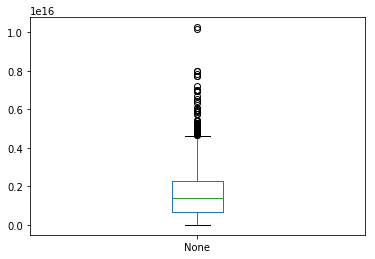

In [45]:
# boxplot
pt_dt_pos_diff.plot(kind='box')

plt.show()

In [46]:
# data regarding these outliers 
data.ix[outliers_pt_dt.index].head()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
17072,114567,7450.0,7450.0,funded,Computers,Services,Training and certification for his computer an...,US,United States,"Atlanta, Georgia",...,USD,131.0,2009-06-10 20:14:22,NaT,2009-03-22 07:00:00,2009-06-21 02:37:18,26.0,236,male,monthly
17358,117254,175.0,175.0,funded,Pigs,Agriculture,To buy pig feed,PH,Philippines,"Surallah, South Cotabato",...,PHP,125.0,2009-06-22 00:58:11,NaT,2009-05-06 07:00:00,2009-06-22 02:05:24,6.0,6,female,bullet
17418,114264,5750.0,5750.0,funded,Services,Services,To buy a car for transporting packages,US,United States,"Queens, New York",...,USD,131.0,2009-06-09 16:55:37,NaT,2009-03-31 07:00:00,2009-06-20 20:18:43,27.0,171,male,monthly
36690,246230,1500.0,1500.0,funded,Butcher Shop,Food,To purchase meat for resale,KG,Kyrgyzstan,Tokmak,...,KGS,135.0,2010-11-09 05:39:58,NaT,2010-09-14 07:00:00,2010-11-15 18:34:32,7.0,46,"female, female, female, female",monthly
37027,245762,700.0,700.0,funded,Restaurant,Food,Purchase of ingredients,PH,Philippines,"Puerto Princesa, Palawan",...,PHP,145.0,2010-11-06 11:49:45,NaT,2010-09-20 07:00:00,2010-11-06 23:45:16,8.0,26,female,irregular


In [47]:
# the difference between the funded_time and posted_time in these outliers
(data.ix[outliers_pt_dt.index]['funded_time'] - data.ix[outliers_pt_dt.index]['posted_time']).describe()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


count                       135
mean     7 days 11:06:35.251851
std      8 days 06:36:41.484789
min             0 days 00:56:53
25%             2 days 16:39:58
50%             3 days 22:15:03
75%             8 days 06:18:38
max            39 days 14:23:22
dtype: object

There are a few outliers regarding this case. However, when analysing them, we notice that in all of them the difference between the posted_time and funded_time is acceptable, which means that although the disbursal was made long before the posted_time, the loan got funded almost immediatly. This could suggest that these cases were somehow managed by Kiva or the Field Partners.

I will opt for their maintenance in the analysis.

**2.3) 'funded_time' and 'disbursed_time'**

In [48]:
(data['funded_time'] - data['disbursed_time']).describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

Here I focused on the cases where the disbursed_time was filled after the loan was funded. I left apart from the cases where the disbursed_time appeared before the funded_time.


In [49]:
# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disbursed_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

I will now divide the analysis between the cases when there was a field partner involved and when there was not.

*Field partner involved*

In [50]:
# cases where the disbursal is made after the funded_time, where there is a field partner involved
dt_ft_pos_partner = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].notnull())]

# time difference between the two
dt_ft_pos_diff_partner = dt_ft_pos_partner['disbursed_time'] - dt_ft_pos_partner['funded_time']

# describe
dt_ft_pos_diff_partner.describe()

count                     104590
mean     17 days 06:47:49.884291
std      12 days 20:47:08.139505
min              0 days 00:01:24
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max             88 days 23:25:52
dtype: object

In [51]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, with a field partner
outliers_dt_ft_partner = outliers_zscore(dt_ft_pos_diff_partner, 3)

# describe
outliers_dt_ft_partner.describe()

count    3214.000000
mean        4.192525
std         0.765157
min         3.002844
25%         3.487668
50%         4.166138
75%         4.916974
max         5.572261
dtype: float64

*Field partner not involved*

In [52]:
# cases where the disbursal is made after the funded_time, where there is not a field partner involved
dt_ft_pos_partner_not = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].isnull())]

# time difference between the two
dt_ft_pos_diff_partner_not = dt_ft_pos_partner_not['disbursed_time'] - dt_ft_pos_partner_not['funded_time']

# describe
dt_ft_pos_diff_partner_not.describe()

count                      13030
mean      8 days 14:59:16.826477
std      10 days 20:39:23.626387
min              0 days 00:00:17
25%       2 days 20:21:33.750000
50%              5 days 12:25:15
75%       9 days 13:06:44.250000
max            182 days 08:31:57
dtype: object

In [53]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, and NO field partner
outliers_dt_ft_partner_not = outliers_zscore(dt_ft_pos_diff_partner_not, 3)

# describe
outliers_dt_ft_partner_not.describe()

count    301.000000
mean       4.579016
std        1.698910
min        3.001596
25%        3.346945
50%        3.989094
75%        5.169267
max       15.996315
dtype: float64

In [54]:
# distribution among countries of the outliers with a field partner involved
data.ix[outliers_dt_ft_partner.index].country_name.value_counts()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Kenya                 787
Nigeria               565
Ghana                 493
India                 336
South Africa          263
Somalia               136
Senegal                78
Tanzania               77
Costa Rica             61
Myanmar (Burma)        41
Colombia               41
Nicaragua              32
Mozambique             28
Malawi                 26
Kyrgyzstan             24
Belize                 24
Mexico                 20
Moldova                16
Honduras               16
Haiti                  14
Dominican Republic     14
Suriname               12
Georgia                11
Thailand               10
Zambia                  9
Mongolia                8
Peru                    8
Sierra Leone            7
Vietnam                 7
Jordan                  7
Cambodia                7
Uganda                  4
Zimbabwe                4
China                   4
Pakistan                4
Indonesia               4
Mali                    4
Turkey                  4
Namibia     

In [55]:
# distribution among countries of the outliers with no field partner involved
data.ix[outliers_dt_ft_partner_not.index].country_name.value_counts()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Kenya            290
United States     11
Name: country_name, dtype: int64

Looking at the distribution of the outliers among countries, however, we notice that they are somewhat representative, either with or without a partner involved, so I will opt to keep the values for further analysis.

## 2) Data Story

Now that the data is clean, we want to start by study the characteristics of the main variables and how they interacted with each other over time.

In [56]:
# setting seaborn
sns.set()

##### Evolution of the number of loans in each phase: 2006-2017

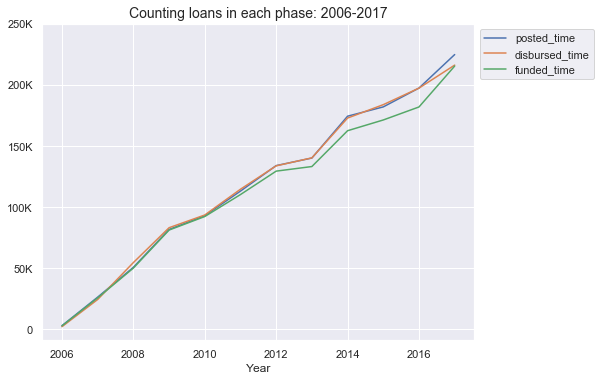

In [57]:
# 2006 - 2017

# main variables
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)

# formatting
plt.yticks([0, 50000, 100000, 150000, 200000, 250000], ['0', '50K', '100K', '150K', '200K', '250K'])
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2017", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In a first look, we notice three major time periods:

**Until 2010**, the number of posted loans were closely matched in time by the amount of fundings and disbursals. After that, **between 2010 and 2014**, we started to see a clear separation between each of the main variables: it suggests that the loans, continuing with almost always a close match between the posting phase and disbursal, started to lose its efficiency regarding the funding of the projects.  

**After 2014** till the end, the differences continued to aggravate between the postings and fundings, and the number of disbursals and postings became just a bit volatile over time. Curiously, the number of fundings gained proximity with the number of disbursals, especially in the last year.

Still, this could be related to missing values or other factors, so it deserves further exploration.

**2006-2010**

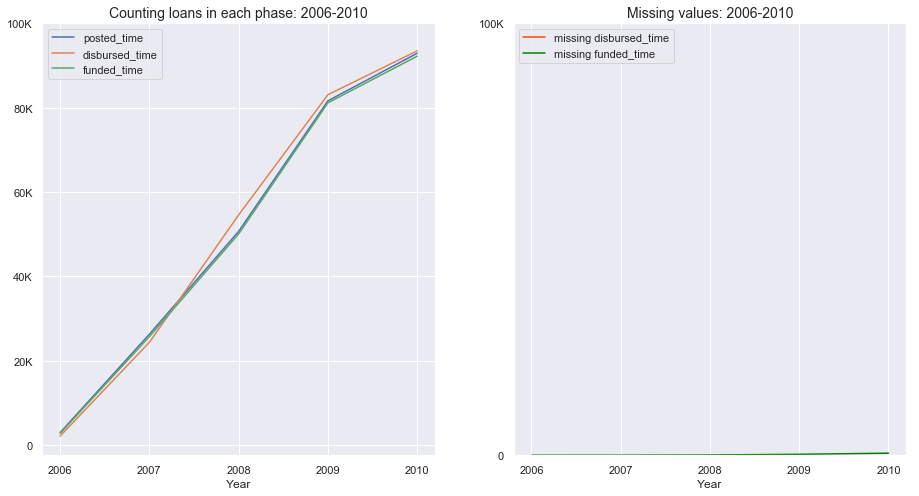

In [58]:
# 2006 - 2010

# main variables
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)

# formatting
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K', '60K', '80K', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2010", fontsize=14)
plt.legend(loc='upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:1].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:5].plot(grid=True, label="missing funded_time", color='green')

# formatting
plt.yticks([0, 100000], ['0', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Missing values: 2006-2010", fontsize=14)
plt.legend(loc='upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

As said before, the process was smooth until 2010.

**2010-2014**

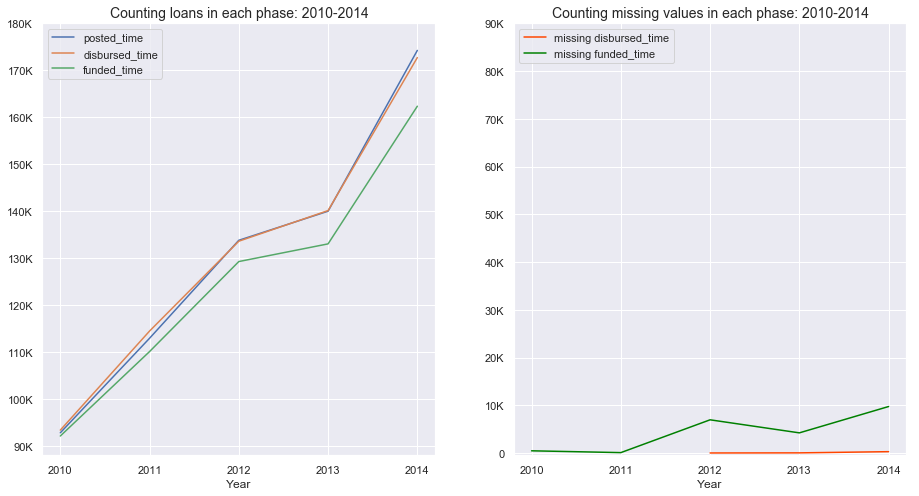

In [59]:
# 2010 - 2014

# main variables
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)

# formatting
plt.yticks([90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000], ['90K', '100K', '110K', '120K', '130K', '140K', '150K', '160K', '170K', '180K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[1:4].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 2000, 4000, 6000, 8000, 10000], ['0', '2K', '4K', '6K', '8K', '10K'])
# plt.yticks([0, 10000, 20000, 180000], ['0', '10K', '20K', '180K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K', '90K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

Between 2010 and 2014, the funding started to lose track of the posted loans mainly between 2010 and 2011. This difference, however, could be due to the cyclical nature of the process, as it will be shown below. Thereafter, the difference was mostly due to the funded missing values.

**2014-2017**

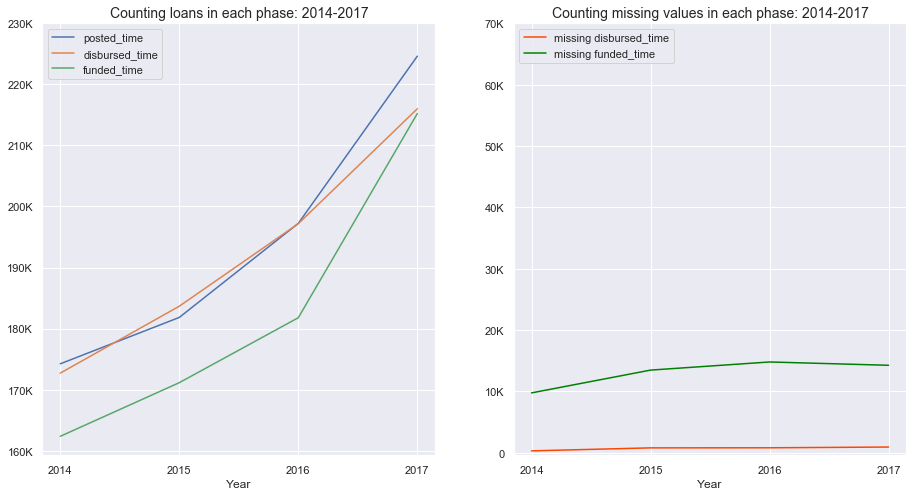

In [60]:
# 2014 - 2017

# main variables 
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)

# formatting
plt.yticks([160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000], ['160K', '170K', '180K', '190K', '200K', '210K', '220K', '230K'])
plt.locator_params(axis='x', nbins=5)
# plt.locator_params(axis='y', nbins=5) 
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[3:].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 4000, 8000, 12000, 16000], ['0', '4K', '8K', '12K', '16K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

In the last phase, although the difference between the number of missing values of the disbursals and fundings remained relatively constant, the number of fundings augmented significantly, equalizing the number of disbursals on the final stretch.

Hence, we can see that the deviation increase was mostly due to the augment in missing values until 2014. If we took that apart, the lines are somewhat at the same pace. This was not the case, however, during the final 4 years. What made that better?

When looking at the disaggregation by month, we can see the **cyclical nature** of the journey of Kiva loans.

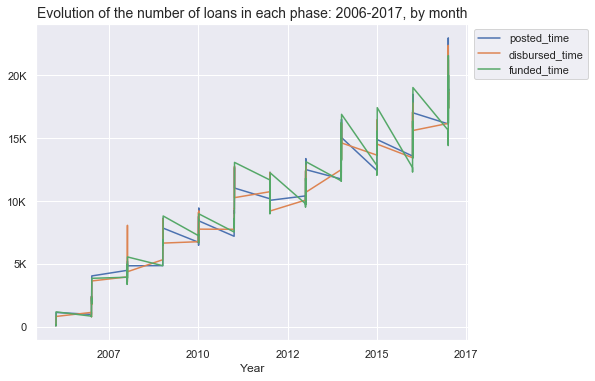

In [61]:
# evolution of the main variables, by month
evol_posted = data[data['posted_time'].notnull()]['posted_time']
evol_disbursed = data[data['disbursed_time'].notnull()]['disbursed_time']
evol_funded = data[data['funded_time'].notnull()]['funded_time']

# plot months (except 2018)
evol_posted.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)
evol_disbursed.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-4].plot(grid=True)
evol_funded.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)

plt.locator_params(axis='x', nbins=5)
plt.xticks([2007500, 2010000, 2012500, 2015000, 2017500], ["2007", "2010", "2012", "2015", "2017"])
plt.yticks([0, 5000, 10000, 15000, 20000], ["0", "5K", "10K", "15K", "20K"])
plt.xlabel("Year")
plt.title("Evolution of the number of loans in each phase: 2006-2017, by month", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

These cycles suggest that Kiva gather many loan requests before they post on their website. The fundings and disbursals follow the announcements (or, since the disbursal is the first to occur, the posting and funding follow the disbursals).

##### Now, looking at the time differences between the main variables

- **'posted_time' vs 'disbursed_time'**

In [62]:
# posted_time - disbursed_time
post_disb = data['posted_time'] - data['disbursed_time']

In [63]:
post_disb.describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

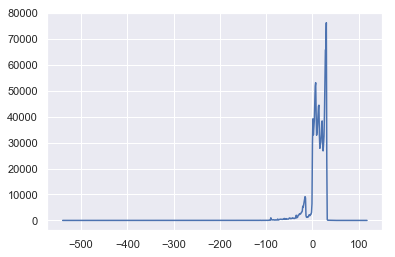

In [64]:
# Glimpse of the distribution
post_disb.dt.days.value_counts().sort_index().plot()

In [65]:
# difference between disbursal and posting between -35 and +32 days, in percentage
int(round(post_disb.dt.days.value_counts().sort_index()[-35:32].sum()/post_disb.dt.days.value_counts().sum()*100))

98

In [66]:
# difference between disbursal and posting between 0 and +32 days, in percentage
int(round(post_disb.dt.days.value_counts().sort_index()[0:32].sum()/post_disb.dt.days.value_counts().sum()*100))

90

In [67]:
# positive difference between disbursal and posting, in percentage
int(round(post_disb.dt.days.value_counts().sort_index()[0:].sum()/post_disb.dt.days.value_counts().sum()*100))

90

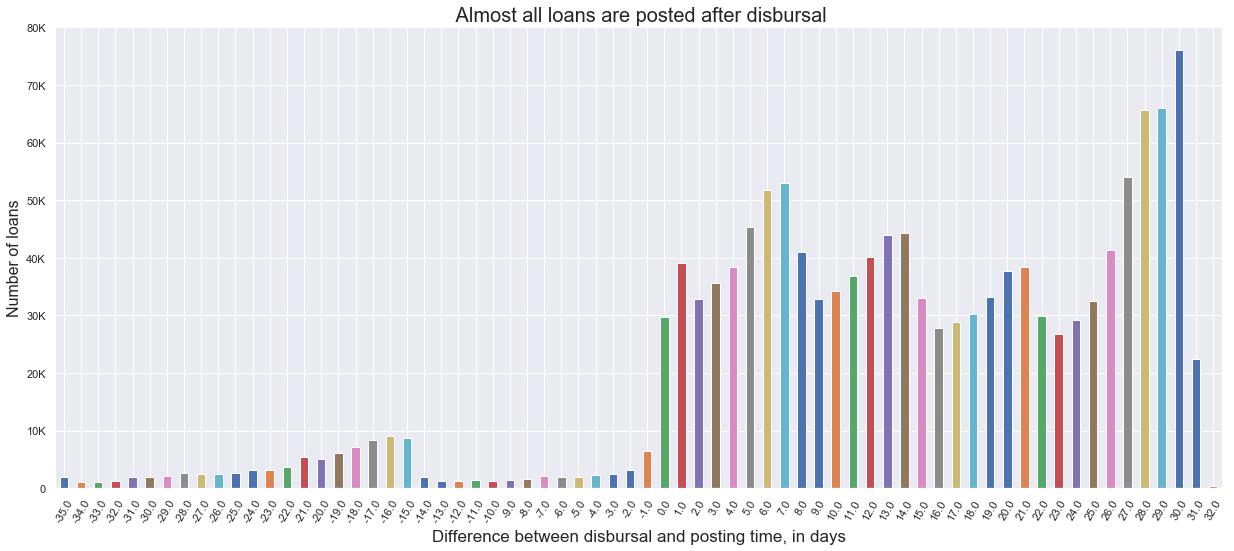

In [68]:
# distribution of 98% of the selected data
post_disb.dt.days.value_counts().sort_index()[-35:32].plot(kind='bar')

# formatting
plt.title(" Almost all loans are posted after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between disbursal and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

- **98% of the differences between the time of disbursal and posting of loans occur on a range of -35 days and +32 days**.


- Moreover, **90% of the differences are positive**, that is, pre-disbursals.

As we can confirm, most (at least 90%) of the disbursals are made by field partners, the only ones who can pre-disburse.

- **'posted_time' vs 'funded_time'**

In [69]:
# funded_time - posted_time
fund_post = data['funded_time'] - data['posted_time']

In [70]:
fund_post.describe()

count                    1355118
mean     12 days 15:14:31.848660
std      13 days 13:00:26.422088
min              0 days 00:02:00
25%       3 days 13:15:20.250000
50%              7 days 18:30:50
75%      18 days 11:47:17.250000
max            533 days 17:22:00
dtype: object

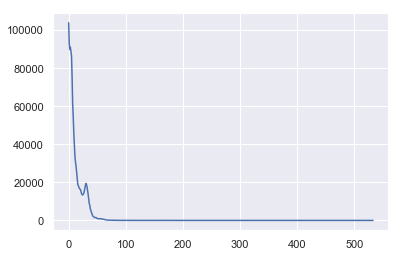

In [71]:
# Glimpse of the distribution
fund_post.dt.days.value_counts().sort_index().plot()

In [72]:
# difference between funding and posting between 0 and +50 days, in percentage
int(round(fund_post.dt.days.value_counts().sort_index()[0:50].sum()/fund_post.dt.days.value_counts().sum()*100))

99

In [73]:
# difference between funding and posting between 0 and +30 days, in percentage
int(round(fund_post.dt.days.value_counts().sort_index()[0:30].sum()/fund_post.dt.days.value_counts().sum()*100))

89

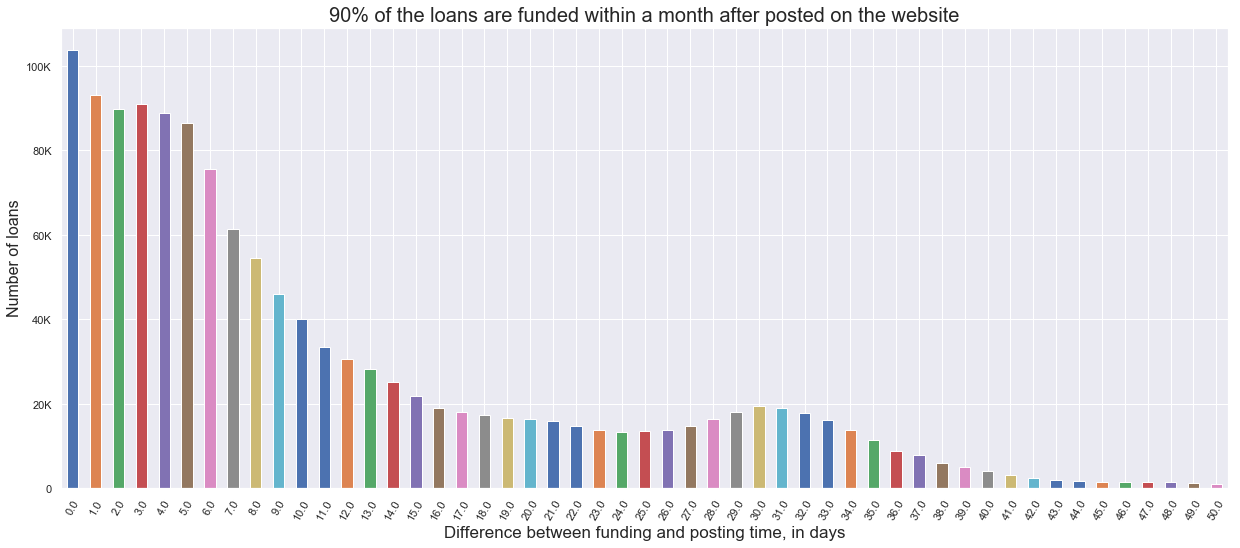

In [74]:
# distribution of 99% of the selected data
fund_post.dt.days.value_counts().sort_index()[0:50].plot(kind='bar')

# formatting
plt.title("90% of the loans are funded within a month after posted on the website", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

When we look at the time a loan takes to get funded **since the time it is posted on Kiva website**, we see that **99% of them are funded within 50 days, and almost 90% within a month**.

- **'disbursed_time' vs 'funded_time'**

Now, since we know that most of the loans are pre-disbursed, we should now take a look at the combination of the two previous analysis, that is, at the difference between the time of disbursal and funding. 

In [75]:
# funded_time - disbursed_time
fund_disb = data['funded_time'] - data['disbursed_time']

In [76]:
fund_disb.describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

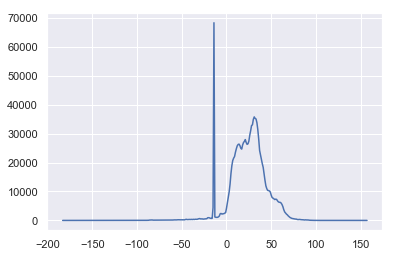

In [77]:
# Glimpse of the distribution
fund_disb.dt.days.value_counts().sort_index().plot()

In [78]:
# difference between funding and disbursal between -18 and +70 days
int(round(fund_disb.dt.days.value_counts().sort_index()[-18:70].sum()/fund_disb.dt.days.value_counts().sum()*100))

98

In [79]:
# when the disbursal occurs only after the funding is complete
int(round(fund_disb.dt.days.value_counts().sort_index()[-3000:0].sum()/fund_disb.dt.days.value_counts().sum()*100))

9

In [80]:
# when the disbursal occurs 14 days after the loan is funded
int(round(fund_disb.dt.days.value_counts().sort_index()[-14].sum()/fund_disb.dt.days.value_counts().sum()*100))

5

In [81]:
# when the disbursal occurs until 14 days after the loan is funded
int(round(fund_disb.dt.days.value_counts().sort_index()[-14:0].sum()/fund_disb.dt.days.value_counts().sum()*100))

7

In [82]:
# difference between funding and disbursal between 0 and +30 days
int(round(fund_disb.dt.days.value_counts().sort_index()[0:30].sum()/fund_disb.dt.days.value_counts().sum()*100))

53

In [83]:
# difference between funding and disbursal between 0 and +60 days
int(round(fund_disb.dt.days.value_counts().sort_index()[0:60].sum()/fund_disb.dt.days.value_counts().sum()*100))

88

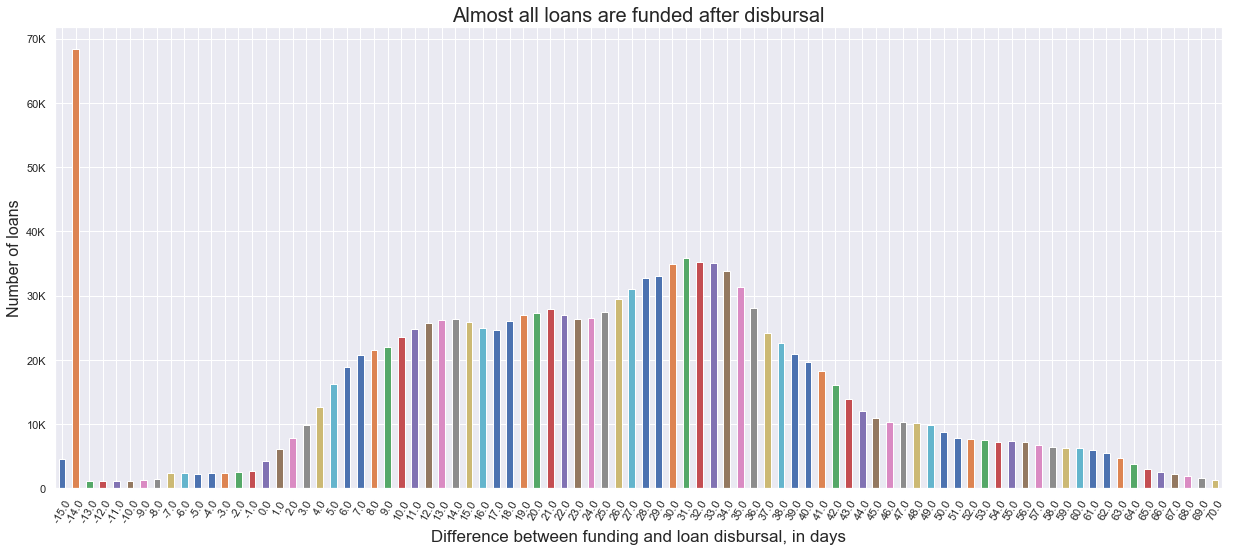

In [84]:
# distribution of 98% of the total data
fund_disb.dt.days.value_counts().sort_index()[-15:70].plot(kind='bar')

# formatting
plt.title("Almost all loans are funded after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and loan disbursal, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

As we can see, close to 10% of the total loans are disbursed after the funding is complete, and 5% occur 14 days after the time of funding.

In most cases, a pre-disbursal occurs and only then the funding period commences.

Confirming if the 5% cases where disbursal occurs 14 days after funding are distributed over time or concentrated in a few days:

In [85]:
# when disbursal occurs 14 days after funding time
forteen_days = data[(data['funded_time'] - data['disbursed_time']).dt.days == -14]['funded_time']

# in how many months this occurs
forteen_days.map(lambda x: 1000*x.year + x.month).value_counts().sort_index().count()

127

It is regular over time, suggesting, again, the cyclical nature of the loan process.

- Since this analysis includes cases where the disbursal occurs after the posting time, now we will look at **the real time a loan takes to get funded**. To do that, we need the difference between the funding time and the disbursal or posting time, depending on which of these occurred first.

In [86]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# loan time 1 & 2
loan_time_1 = start_1['funded_time'] - start_1['posted_time']
loan_time_2 = start_2['funded_time'] - start_2['disbursed_time']

#concatenate
loan_time = pd.concat([loan_time_1.dt.days, loan_time_2.dt.days], axis=0)

In [87]:
# loans that get funded within a month
int(round(loan_time.value_counts().sort_index()[0:30].sum()/loan_time.value_counts().sum()*100))

60

In [88]:
# loans that get funded within 2 months
int(round(loan_time.value_counts().sort_index()[0:60].sum()/loan_time.value_counts().sum()*100))

97

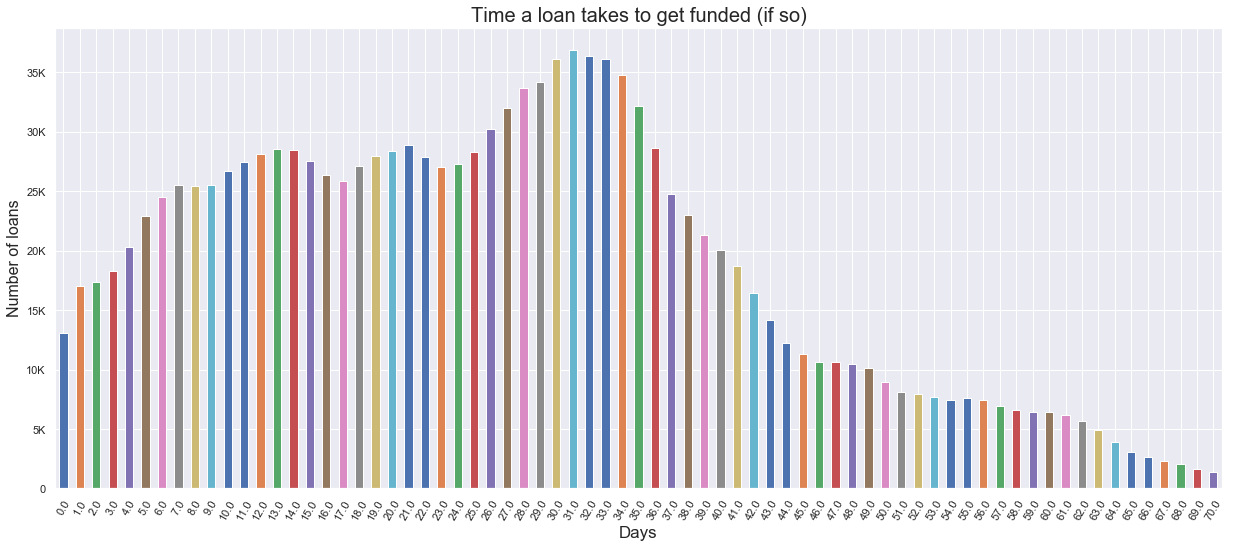

In [89]:
# distribution of the data of interest
loan_time.value_counts().sort_index()[0:70].plot(kind='bar')

# formatting
plt.title("Time a loan takes to get funded (if so)", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000], ['0', '5K', '10K','15K', '20K', '25K', '30K', '35K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

Estimating the probability density function, using an histogram and KDE:

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


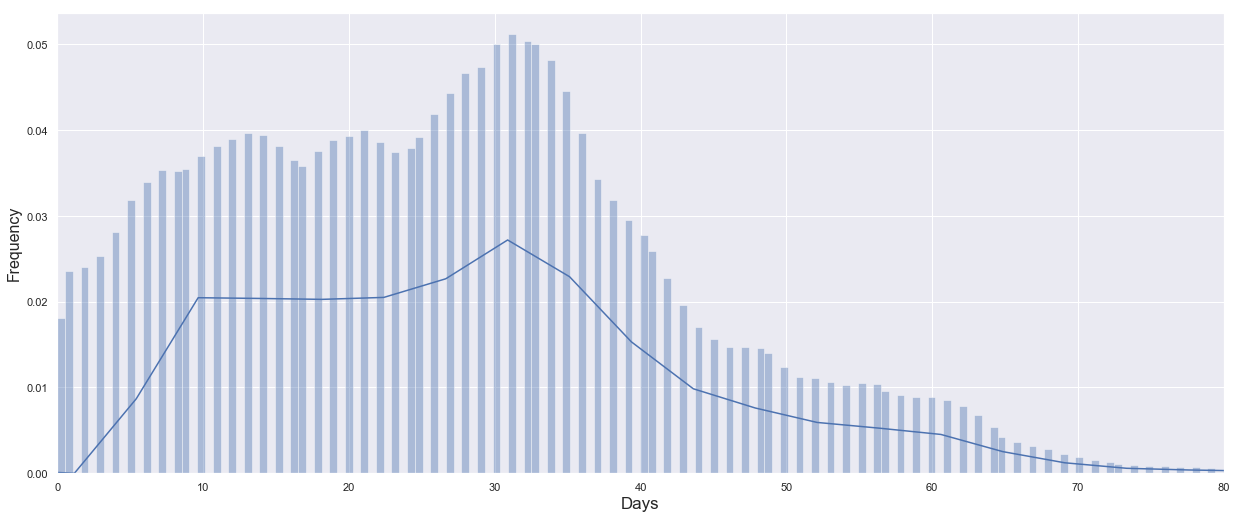

In [90]:
# drop nulls
loan_time_notnull = loan_time.dropna()

# distribution (histogram and kde)
sns.distplot(loan_time_notnull, bins=1000)

plt.xlim(0, 80)
plt.xlabel("Days", fontsize=17)
plt.ylabel("Frequency", fontsize=16)

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [91]:
# percentage of loans that are only disbursed after they are funded
round(data[data['disbursed_time'] > data['funded_time']].count().funded_amount/data.posted_time.count()*100)

8.0

In [92]:
# loans not funded yet
round(data[(data['posted_time'].notnull()) & (data['funded_time'].isnull())].count().loan_id/data.posted_time.count()*100)

5.0

5% of all loans are not funded yet. Of those that are:

- **Close to 60% are funded within a month**. This happens almost in a linear way as the month advances.
- **97% are funded within 2 months**

As a reminder, 8% of the total loans are only disbursed after they are funded (with 7% within two weeks). Considering these cases, this means that 99% of the loans are funded within 2 months and 2 weeks.

#####  **What may cause delays, then?**

##### Does some countries have impact regarding this question?

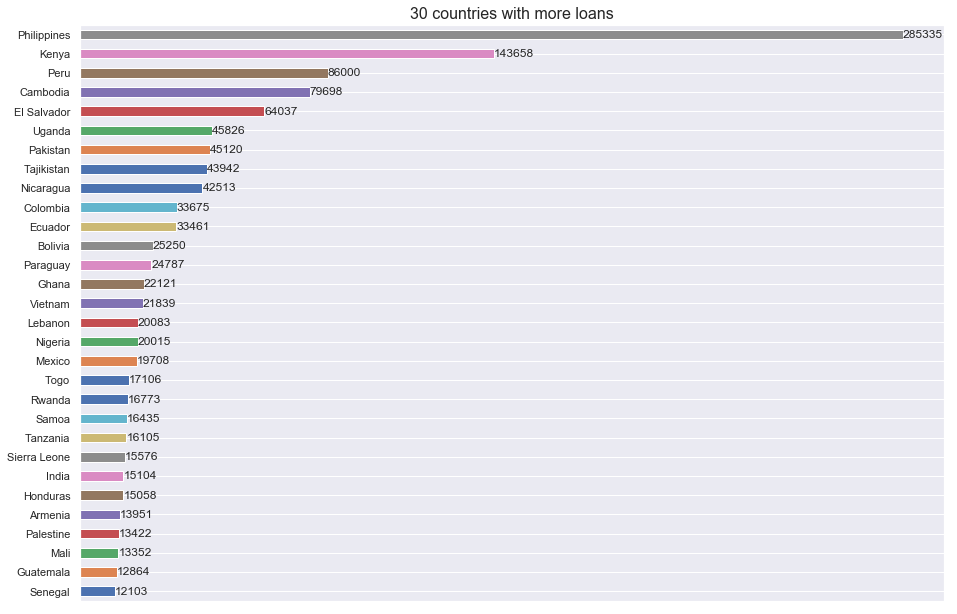

In [93]:
# Distribution of loans across countries

country_loans = data['country_name'].value_counts(ascending=True)[-30:]
country_loans_idx = data['country_name'].value_counts().index
pos = np.arange(len(country_loans))

# add the values to the side of each bar
for p, cidx, cl in zip(pos, country_loans_idx, country_loans):
    plt.annotate(cl, xy=(cl, p), va='center')


# formatting
plt.xticks([])
plt.title("30 countries with more loans", fontsize=16)
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0.6)

country_loans.plot(kind='barh')
plt.show()

In [94]:
# 6 countries with more loan requests
print(data['country_name'].value_counts()[0:6])

# percentagewise
print(round(data['country_name'].value_counts()[0:6].sum()/data['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143658
Peru            86000
Cambodia        79698
El Salvador     64037
Uganda          45826
Name: country_name, dtype: int64
50.0


**Half of the loans go to 6 countries.**

In [95]:
# 6 countries with more loan requests
print(data['country_name'].value_counts()[0:20])

# percentagewise
print(round(data['country_name'].value_counts()[0:20].sum()/data['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143658
Peru            86000
Cambodia        79698
El Salvador     64037
Uganda          45826
Pakistan        45120
Tajikistan      43942
Nicaragua       42513
Colombia        33675
Ecuador         33461
Bolivia         25250
Paraguay        24787
Ghana           22121
Vietnam         21839
Lebanon         20083
Nigeria         20015
Mexico          19708
Togo            17106
Rwanda          16773
Name: country_name, dtype: int64
77.0


**77% of the loans go to 20 countries.**

#####  When a loan is funded (96% of the data), how long does it take to get that funding, on average, in each country? Does the number of loans they have have any impact?

In [96]:
# redefine country_loans: include all
country_loans = data['country_name'].value_counts(ascending=True)

# select data
data_2 = pd.concat([start_1, start_2], axis=0)
data_2 = data_2.set_index('country_name')

# total differences
start_1_countries = data_2[data_2['posted_time'] < data_2['disbursed_time']]
start_2_countries = data_2[data_2['posted_time'] > data_2['disbursed_time']]

# loan_time_countries 1 & 2
loan_time_1_countries = start_1_countries['funded_time'] - start_1_countries['posted_time']
loan_time_2_countries = start_2_countries['funded_time'] - start_2_countries['disbursed_time']

#concatenate
loan_time_countries = pd.concat([loan_time_1_countries.dt.days, loan_time_2_countries.dt.days], axis=0)
loan_time_amounts = pd.concat([start_1_countries.loan_amount, start_2_countries.loan_amount], axis=0)

# create list of countries and respective mean time of loan funding
countries_nr_loans = []
avg_time_fund = []
size_loans = []

for i in range(country_loans.count()):
    if country_loans.index[i] in loan_time_countries.index:
        countries_nr_loans.append(country_loans[i])
        avg_time_fund.append(round(loan_time_countries.loc[country_loans.index[i]].mean()))
        size_loans.append(round(loan_time_amounts.loc[country_loans.index[i]].mean())/10)

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


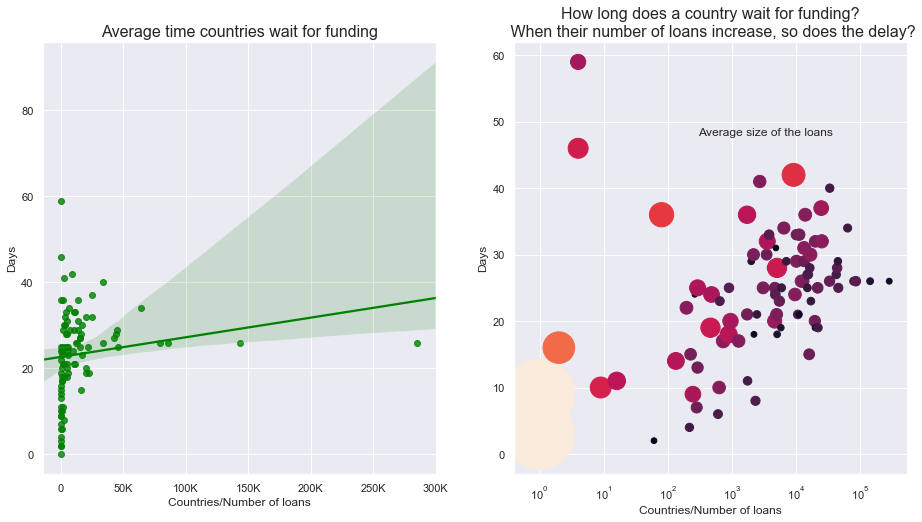

In [97]:
# create dataframe
loan_increase_time = pd.DataFrame({'countries_nr_loans': countries_nr_loans, 'avg_time_fund': avg_time_fund, 'size_loans': size_loans})

# scatter plot
plt.subplot(1, 2, 1)
# plt.scatter(countries_nr_loans, avg_time_fund)
sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time, color="green")
plt.title("Average time countries wait for funding", fontsize=16)
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000], ['0', '50K', '100K', '150K', '200K', '250K', '300K'])
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")


# scatter plot - log
plt.subplot(1, 2, 2)
plt.scatter(countries_nr_loans, avg_time_fund, s=size_loans, c=np.log10(size_loans))   
# sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time)
plt.text(300, 48, 'Average size of the loans')

# formatting
plt.title("How long does a country wait for funding?\n When their number of loans increase, so does the delay?", fontsize=16)
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")
plt.xscale('log') 

# plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

For countries with a few number of loans, the variation of average time to get the funding is significant. As soon as the number of loans start to increase, the average number of days to get the funding rapidly get close to 30, where most of them reside.

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


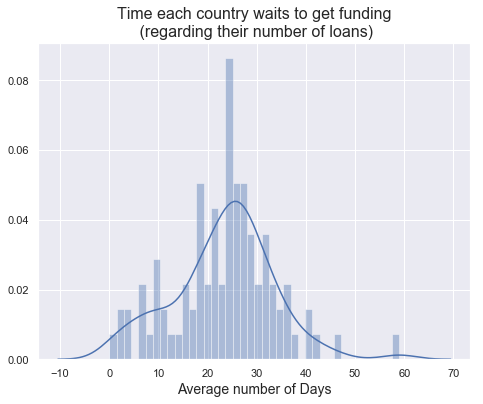

In [98]:
# histogram of the average number of days a country waits to get funding
sns.distplot(avg_time_fund, bins=40)

# formatting
plt.xlabel("Average number of Days", fontsize=14)
plt.title("Time each country waits to get funding\n (regarding their number of loans)", fontsize=16)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

Here is the distribution of the time each country waits to get funding, which was suggested on the previous analysis.

#####  When a loan is funded, do bigger loan amounts take more time to fund, on average?

In [99]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_3 = pd.concat([start_1, start_2], axis=0)
data_3 = data_3.set_index('loan_amount')
data_3['loan_amount'] = data_3.index

# total differences (only considering the ones which were funded)
start_1_loan = data_3[(data_3['posted_time'] < data_3['disbursed_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]
start_2_loan = data_3[(data_3['posted_time'] > data_3['disbursed_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]

# loan_time_loans 1 & 2
loan_time_1_loan = start_1_loan['funded_time'] - start_1_loan['posted_time']
loan_time_2_loan = start_2_loan['funded_time'] - start_2_loan['disbursed_time']

#concatenate
loan_time_loan_amounts = pd.concat([loan_time_1_loan.dt.days, loan_time_2_loan.dt.days], axis=0)


# create list of loan_amounts and mean time of funding
loan_amount_size = sorted(list(set(loan_time_loan_amounts.index)))
avg_time_loan = []

for i in loan_amount_size:
    avg_time_loan.append(round(loan_time_loan_amounts.loc[i].mean()))

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


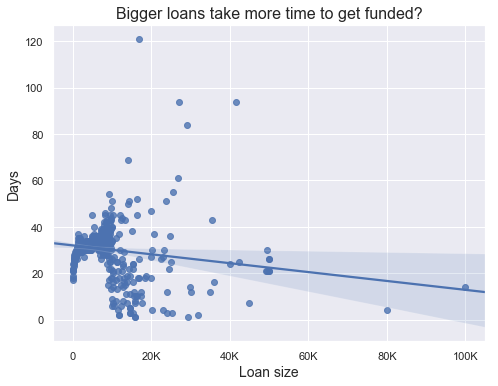

In [100]:
# create dataframe
loan_amount_time = pd.DataFrame({'loan_amount_size': loan_amount_size, 'avg_time_loan': avg_time_loan})

# scatter plot
sns.regplot(x='loan_amount_size', y='avg_time_loan', data=loan_amount_time)

# formatting
plt.title("Bigger loans take more time to get funded?", fontsize=16)
plt.xticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])
plt.xlabel("Loan size", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

As suggested in the previous analysis, there is a **small negative correlation between the size of the loan and the time it takes to get funded**, which is not expected, usually.

##### **Does the sector of the loan influences the time of funding?**

Distribution of loans among sectors

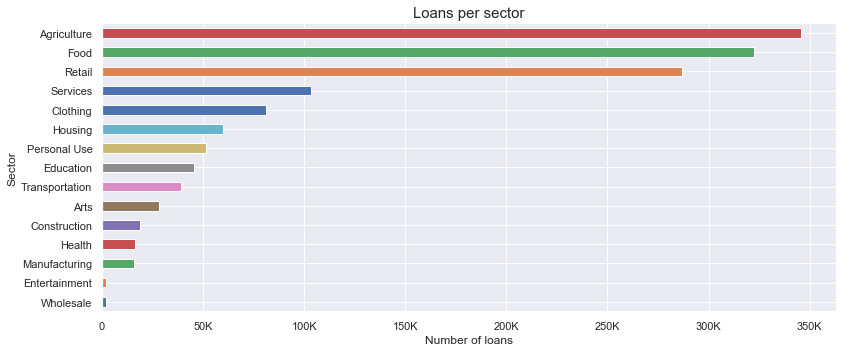

In [101]:
# quantity of loans each sector has
data['sector_name'].value_counts(ascending=True).plot(kind='barh')

# formatting
plt.title("Loans per sector", fontsize=15)
plt.xlabel("Number of loans")
plt.ylabel("Sector")
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000], ["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K"])
plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0, hspace=0.6)
plt.show()

In [102]:
# percentage of loans for the 3 main sectors
print(round(data['sector_name'].value_counts()[:3]/data['sector_name'].value_counts().sum()*100))

Agriculture    24.0
Food           23.0
Retail         20.0
Name: sector_name, dtype: float64


**67% of the loans go to 3 sectors**: Agriculture (24%), Food (23%) and Retail (20%)

In [103]:
# percentage of loans for the 5 main sectors
print(round(data['sector_name'].value_counts()[:5].sum()/data['sector_name'].value_counts().sum()*100))

80.0


In [104]:
# select data
data_4 = data[['sector_name', 'disbursed_time', 'posted_time', 'funded_time']]
data_4 = data_4.set_index('sector_name')

# differences
start_1_sector = data_4[data_4['posted_time'] < data_4['disbursed_time']]
start_2_sector = data_4[data_4['posted_time'] > data_4['disbursed_time']]

# sector_time 1 & 2
sector_time_1 = start_1_sector['funded_time'] - start_1_sector['posted_time']
sector_time_2 = start_2_sector['funded_time'] - start_2_sector['disbursed_time']

#concatenate
sector_time = pd.concat([sector_time_1.dt.days, sector_time_2.dt.days], axis=0)

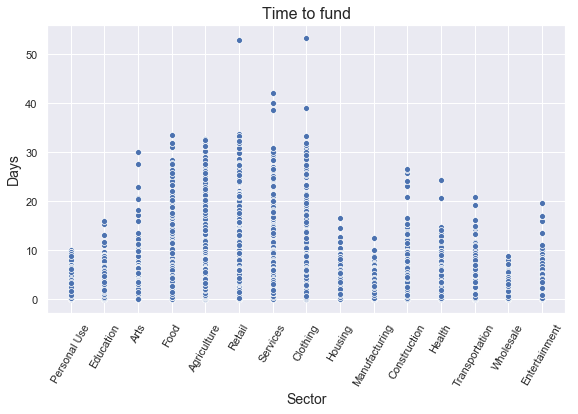

In [105]:
# create dataframe
sectors = pd.DataFrame({'sector_time': sector_time, 'sectors': sector_time.index})

# scatter plot
sns.scatterplot(x='sectors', y='sector_time', data=sectors)

# formatting
plt.title("Time to fund", fontsize=16)
plt.yticks([0, 100, 200, 300, 400, 500], ['0', '10', '20','30', '40', '50'])
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.xticks(rotation=60)

plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=0.6, hspace=0.4)
plt.show()

We can notice that **the main 5 sectors (which gather 80% of the loans) are the ones who influence the most a higher delay in fundings.**

##### How do Field partners fit in this analysis?

In [106]:
# field partners 
round(data['partner_id'].count()/data.posted_time.count()*100)

99.0

99% of the loans have a field partner id.

Distribution of loans among field partners

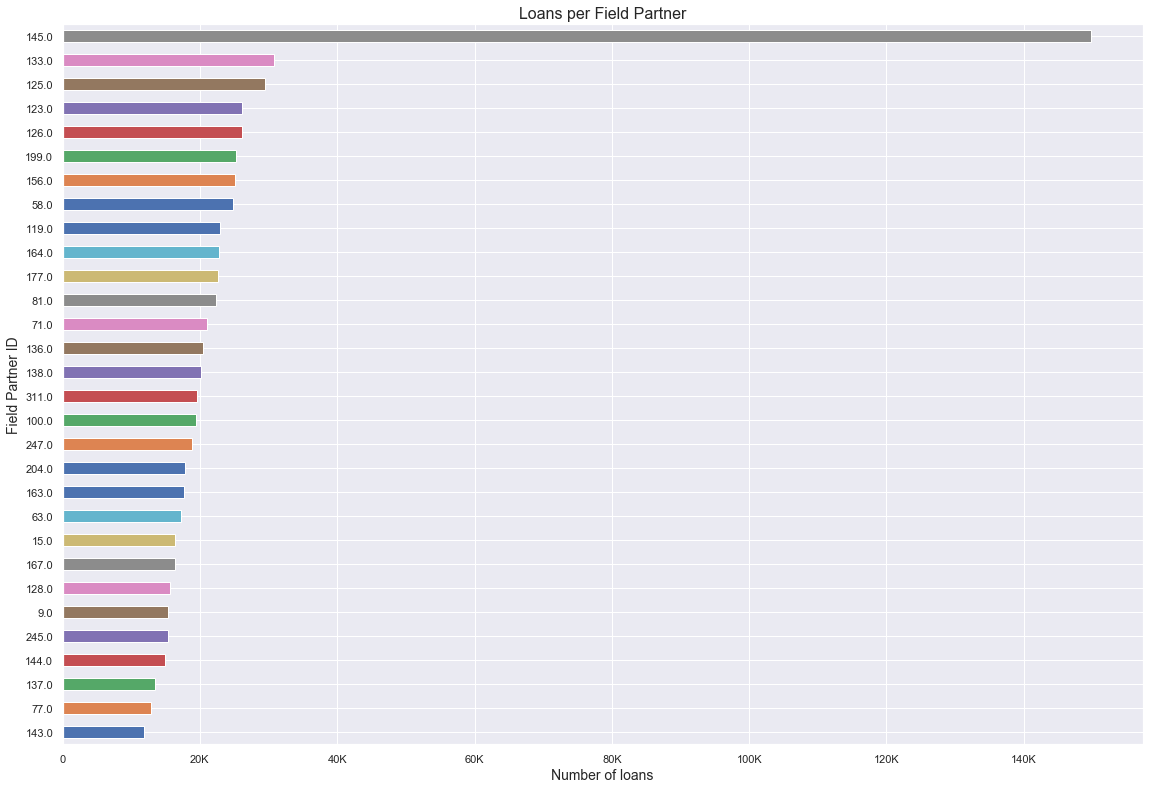

In [107]:
# quantity of loans each sector has
data['partner_id'].value_counts(ascending=True).tail(30).plot(kind='barh')

# formatting
plt.title("Loans per Field Partner", fontsize=16)
plt.xlabel("Number of loans", fontsize=14)
plt.ylabel("Field Partner ID", fontsize=14)
plt.xticks([0, 20000, 40000, 60000, 80000, 100000, 120000, 140000], ["0", "20K", "40K", "60K", "80K", "100K", "120K", "140K"])
plt.subplots_adjust(left=0, bottom=-1.5, right=2.5, top=1, wspace=0, hspace=0.6)
plt.show()

In [108]:
# field partner with more loans (id 145)
round(data['partner_id'].value_counts(ascending=True).tail(1).sum()/data['partner_id'].value_counts(ascending=True).sum()*100)

11.0

In [109]:
# 120 field partners with more loans
round(data['partner_id'].value_counts(ascending=True).tail(120).sum()/data['partner_id'].value_counts(ascending=True).sum()*100)

90.0

In [110]:
len(data['partner_id'].unique())

479

Of the 479 unique field partners, **11%** of the loans are organized by field partner nº 145 and **90%** by 120 field partners.

In [111]:
#total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_5 = pd.concat([start_1, start_2], axis=0)
data_5 = data_5.set_index('partner_id')
data_5['partner_id'] = data_5.index

# total differences 
start_1_field = data_5[data_5['posted_time'] < data_5['disbursed_time']]
start_2_field = data_5[data_5['posted_time'] > data_5['disbursed_time']]

# field_time_loans 1 & 2
field_time_1_loan = start_1_field['funded_time'] - start_1_field['posted_time']
field_time_2_loan = start_2_field['funded_time'] - start_2_field['disbursed_time']

#concatenate
field_time = pd.concat([field_time_1_loan.dt.days, field_time_2_loan.dt.days], axis=0)


# create list of field partners, mean time of funding, and relative amount of loans
field_partners_ids = list(set(field_time.sort_index().index.dropna()))
avg_time_field = []
avg_field_part = []

for i in field_partners_ids:
        avg_time_field.append(round(field_time.loc[i].mean()))
        avg_field_part.append(data['partner_id'].value_counts()[i]/data['partner_id'].value_counts().sum()*100*500)   

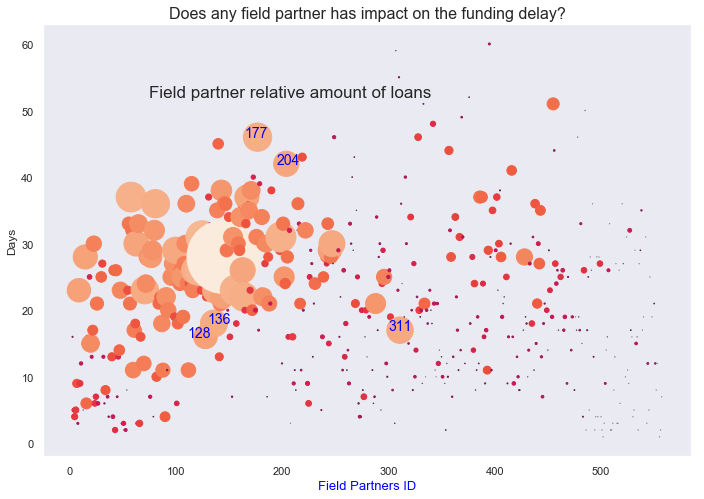

In [112]:
# create dataframe
field_partn_time = pd.DataFrame({'field_partners_ids': field_partners_ids, 'avg_time_field': avg_time_field, 'avg_field_part': avg_field_part})

# scatter plot
plt.scatter(field_partners_ids, avg_time_field, s=avg_field_part, c=np.log10(avg_field_part))   
plt.text(75, 52, 'Field partner relative amount of loans', fontsize=17)

# field partners of interest
plt.text(300, 17, '311', fontsize=14, color='blue') #17
plt.text(111, 16, '128', fontsize=14, color='blue') #16
plt.text(130, 18, '136', fontsize=14, color='blue') #18
plt.text(165, 46, '177', fontsize=14, color='blue') #46
plt.text(195, 42, '204', fontsize=14, color='blue') #42

# formatting
plt.title("Does any field partner has impact on the funding delay?", fontsize=16)
plt.xlabel("Field Partners ID", fontsize=13, color='blue')
plt.ylabel("Days")
plt.grid(False)

plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.6, hspace=0.4)
plt.show()

**There are not many field partners with a considerable size of loans that affect the overall average time loans take to get funded**. Still, a few of them are relatively away from the concentrated 30-day delay (none of them has more than 1.6% of the total number of loans).

##### What is the relationship between the number of lenders and the time it takes to get funding?

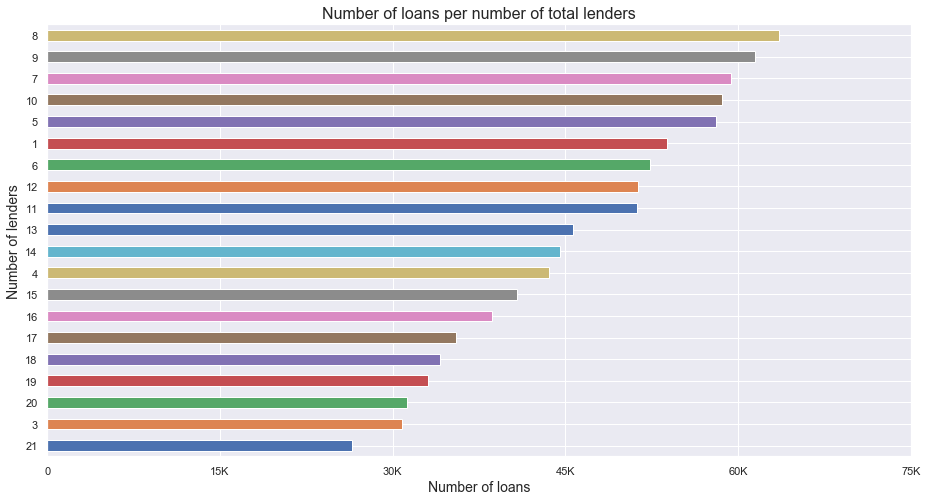

In [113]:
# number of loans per total number of lenders
data['num_lenders_total'].value_counts(ascending=True).tail(20).plot(kind='barh')

# formatting
plt.title("Number of loans per number of total lenders", fontsize=16)
plt.xlabel("Number of loans", fontsize=14)
plt.ylabel("Number of lenders", fontsize=14)
plt.xticks([0, 15000, 30000, 45000, 60000, 75000], ["0", "15K", "30K", "45K", "60K", "75K"])
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

**Conclusion:** There is not a clear pattern between these two variables.

##### Does repayment interval affect delay?

In [114]:
# number of loans per repayment interval
data['repayment_interval'].value_counts()

monthly      777963
irregular    529444
bullet       111364
weekly          622
Name: repayment_interval, dtype: int64

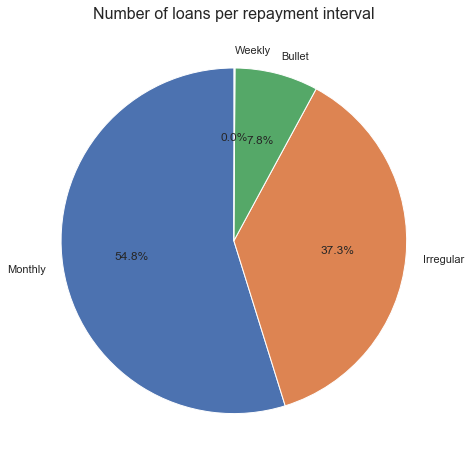

In [115]:
# define sizes
size_monthly = round(data['repayment_interval'].value_counts()[0]/data['repayment_interval'].value_counts().sum(), 3)
size_irregular = round(data['repayment_interval'].value_counts()[1]/data['repayment_interval'].value_counts().sum(), 3)
size_bullet = round(data['repayment_interval'].value_counts()[2]/data['repayment_interval'].value_counts().sum(), 3)
size_weekly = round(data['repayment_interval'].value_counts()[3]/data['repayment_interval'].value_counts().sum(), 3)

# formatting
labels = ["Monthly", "Irregular", "Bullet", "Weekly"]
sizes = [size_monthly, size_irregular, size_bullet, size_weekly]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Number of loans per repayment interval", fontsize=16)
plt.ylabel("")

plt.subplots_adjust(left=0, bottom=-0.5, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [116]:
#total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_6 = pd.concat([start_1, start_2], axis=0)
data_6 = data_6.set_index('repayment_interval')
data_6['repayment_interval'] = data_6.index

# total differences 
start_1_repay = data_6[data_6['posted_time'] < data_6['disbursed_time']]
start_2_repay = data_6[data_6['posted_time'] > data_6['disbursed_time']]

# repay_time_loans 1 & 2
repay_time_1_loan = start_1_repay['funded_time'] - start_1_repay['posted_time']
repay_time_2_loan = start_2_repay['funded_time'] - start_2_repay['disbursed_time']

#concatenate
repay_time = pd.concat([repay_time_1_loan.dt.days, repay_time_2_loan.dt.days], axis=0)

# create list of repayment intervals, mean time of funding, and relative amount of loans
repay_intervals = list(set(repay_time.index))
avg_time_repay = []

for i in repay_intervals:
        avg_time_repay.append(round(repay_time.loc[i].mean()))  

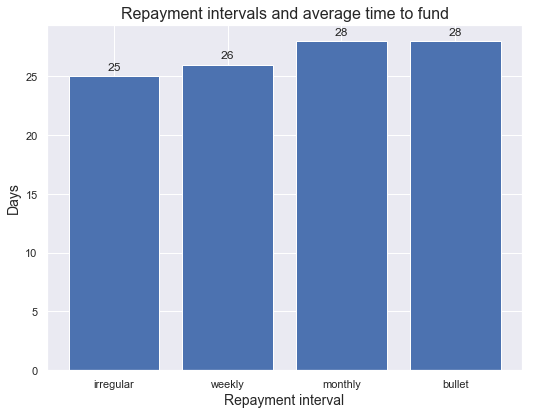

In [117]:
# repayment interval average time to fund
plt.bar(repay_intervals, avg_time_repay)

# formatting
plt.title("Repayment intervals and average time to fund", fontsize=16)
plt.xlabel("Repayment interval", fontsize=14)
plt.ylabel("Days", fontsize=14)

for x, y in zip(repay_intervals, avg_time_repay):
    plt.annotate("%i" % y, (x, y + 0.5), ha='center')

plt.subplots_adjust(left=0, bottom=-0.2, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [118]:
print("Weekly repayments standard deviation:", round(repay_time.loc['weekly'].std()))
print("Bullet repayments standard deviation:",round(repay_time.loc['bullet'].std()))
print("Monthly repayments standard deviation:",round(repay_time.loc['monthly'].std()))
print("Irregular repayments standard deviation:",round(repay_time.loc['irregular'].std()))


Weekly repayments standard deviation: 26
Bullet repayments standard deviation: 18
Monthly repayments standard deviation: 19
Irregular repayments standard deviation: 14


**Conclusion:** The repayment interval does not seem to affect the delay in funding.

##### When the loan is not completely funded, how big  it is?

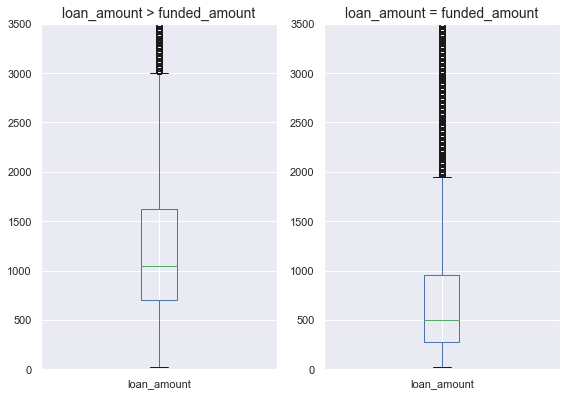

In [119]:
# loan_amount > funded_amount
plt.subplot(1, 2, 1)
data[data['loan_amount'] > data['funded_amount']].loan_amount.plot(kind='box')
plt.title("loan_amount > funded_amount", fontsize=14)
plt.ylim(0, 3500)

# loan_amount = funded_amount
plt.subplot(1, 2, 2)
data[data['loan_amount'] == data['funded_amount']].loan_amount.plot(kind='box')
plt.title("loan_amount = funded_amount", fontsize=14)
plt.ylim(0, 3500)


plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0.2, hspace=0.4)
plt.show()

They were **bigger than usual**, as expected.

### Exploratory data analysis

- When there is a missing disbursed_time value and the loan has been funded:

In [120]:
# Cases where there is a missing disbursed_time and the status is classified as funded
missing_disb = data[(data['disbursed_time'].isna()) & (data['funded_time'].notnull())]
missing_disb.count().funded_time

271

In [121]:
# head
missing_disb.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
37765,1407950,8000.0,8000.0,funded,Clothing,Clothing,support a local business dedicated to providin...,US,United States,NaN,...,USD,NaN,2017-11-02 01:11:32,2017-12-17 22:44:40,NaT,2017-12-16 21:14:45,36.0,56,male,bullet
70179,1164746,3000.0,3000.0,refunded,Services,Services,NaN,US,United States,NaN,...,USD,NaN,2016-10-05 01:28:13,2016-11-10 18:43:40,NaT,2016-11-10 00:40:29,24.0,57,NaN,bullet
70314,1088448,5000.0,5000.0,refunded,Agriculture,Agriculture,NaN,US,United States,NaN,...,USD,NaN,2015-04-15 12:35:57,2015-06-05 00:30:01,NaT,2016-02-11 17:44:48,30.0,106,NaN,bullet
89049,1428619,2000.0,2000.0,funded,Entertainment,Entertainment,fund the renovation of my retail store so my b...,US,United States,NaN,...,USD,NaN,2017-12-05 18:50:15,2018-01-20 12:38:16,NaT,2017-12-23 14:32:29,18.0,25,male,bullet
91347,1084914,125.0,125.0,refunded,Clothing,Clothing,NaN,KE,Kenya,NaN,...,KES,NaN,2014-10-28 06:32:19,2014-12-27 17:45:36,NaT,2014-12-26 19:09:42,3.0,12,NaN,bullet


In [122]:
# general delay, taking into consideration the time of the last disbursal in the data
(max(data['disbursed_time']) - missing_disb['funded_time']).describe()

count                         271
mean     856 days 10:38:41.136531
std      378 days 19:22:38.747084
min              78 days 20:59:20
25%             915 days 17:32:43
50%             931 days 14:42:34
75%             970 days 17:55:31
max            1927 days 06:24:45
Name: funded_time, dtype: object

In [123]:
# As seen before,

# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disbursed_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

There is a general significant difference between the two.

In [124]:
# geographical location of the missing values
missing_disb.country_name.value_counts()

Kenya            216
United States     55
Name: country_name, dtype: int64

In [125]:
# sector name of those missing values 
missing_disb.sector_name.value_counts()

# Note: 97% of the Agriculture cases are from Kenya

Agriculture       79
Services          46
Food              46
Retail            44
Clothing          26
Arts               9
Transportation     7
Construction       5
Entertainment      4
Health             4
Education          1
Name: sector_name, dtype: int64

Since the missing values appear in only two countries in the world, I will generalize and check for outliers by comparing them with the typical delay to disburse in each country.

USA

In [126]:
# cases in the United States where the disbursal is made after the loan is funded
usa_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'United States']

# delay values 
delay_usa = (usa_dt_ft_pos['disbursed_time'] - usa_dt_ft_pos['funded_time'])

# description of the delay to disburse in the United States
print(delay_usa.describe())

# I will consider the mean value for the typical delay to disburse in the United States
delay_usa.mean()

count                      3527
mean     5 days 06:43:32.021831
std      5 days 22:55:18.397383
min             0 days 00:00:17
25%             2 days 00:26:18
50%             3 days 23:05:12
75%      6 days 05:07:38.500000
max           106 days 12:48:50
dtype: object


Timedelta('5 days 06:43:32.021831')

In [127]:
# missing values filtered by country: United States
usa = missing_disb[missing_disb['country_name'] == 'United States']

# description of the delay of disbursal, in the United States, after the loan is funded 
(max(data['disbursed_time']) - usa['funded_time']).describe()

count                          55
mean     248 days 10:26:48.945454
std      398 days 00:49:45.201273
min              78 days 20:59:20
25%       80 days 17:18:49.500000
50%              82 days 14:37:29
75%              99 days 17:58:27
max            1927 days 06:24:45
Name: funded_time, dtype: object

In [128]:
## what to consider for these cases ? which ones are expected?

# 106 (max diff) vs 82 (median)

Kenya

In [129]:
# cases in Kenya where the disbursal is made after the loan is funded
kenya_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'Kenya']

# delay values 
delay_kenya = (kenya_dt_ft_pos['disbursed_time'] - kenya_dt_ft_pos['funded_time'])

# description of the delay to disburse in Kenya
print(delay_kenya.describe())

# I will consider the mean value for the typical delay to disburse in Kenya
delay_kenya.mean()

count                      20659
mean     17 days 11:42:49.691708
std      17 days 07:31:00.633473
min              0 days 00:02:00
25%              5 days 06:34:47
50%             13 days 12:58:22
75%      24 days 14:37:12.500000
max            182 days 08:31:57
dtype: object


Timedelta('17 days 11:42:49.691708')

In [130]:
# missing values filtered by country: Kenya
kenya = missing_disb[missing_disb['country_name'] == 'Kenya']

# description of the delay of disbursal, in Kenya, after the loan is funded
(max(data['disbursed_time']) - kenya['funded_time']).describe()

count                          216
mean     1011 days 06:15:02.481481
std       147 days 12:35:07.238205
min              914 days 11:19:07
25%              921 days 01:30:39
50%       942 days 19:49:48.500000
75%             1023 days 09:07:22
max             1600 days 10:20:21
Name: funded_time, dtype: object

In Kenya, they are all off the scale. I shall consider these values as non-distributed.